In [5]:
# pip install torchsampler

<hr>

<hr>

In [1]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp
# from torchsampler import ImbalancedDatasetSampler


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

import gc

In [2]:
## Hyperparameters
USERNAME = os.getcwd().split('/')[2]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 512
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

THRESHOLD = 0.3
# MIN_ACTIVATION_SIZE = 


cuda
1


In [3]:
def read_df(df_type):
    #username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(USERNAME, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path', 'Intermediate_Predicted_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', USERNAME)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', USERNAME)
    df['Intermediate_Predicted_Path'] = df['Intermediate_Predicted_Path'].str.replace('anw008', USERNAME)
    df['SOP'] = df['XRay_Path'].apply(lambda x: x.split('/')[-1])
    
    df['No_Pneumothorax'] = df['Mask_Path'].str.contains('negative_mask').astype(int)
    df['Yes_Pneumothorax'] = 1 - df['No_Pneumothorax']
    
    
    return df

In [4]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')

In [5]:
train_df

,Mask_Path,XRay_Path,Intermediate_Predicted_Path,SOP,No_Pneumothorax,Yes_Pneumothorax
0,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.00.400800.30.9.2.0.97200258210.26537585746...,0,1
1,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.07.109556.72.6.9.7.18989625890.56335195975...,0,1
2,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.08.203506.65.2.5.0.32924650882.36087017673...,0,1
3,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.15.275672.29.0.5.8.45791925255.74232884473...,0,1
4,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0.0.155.605300.6.541.1.9531666121.6286372288.6...,0,1
...,...,...,...,...,...,...
5107,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1.6.24.917675.78.9.2.7.290789058518169.9211609...,1,0
5108,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1.6.242.576004.0.820.8.7146407544.0803142732.1...,1,0
5109,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1.6.25.866538.21.1.4.0.06305304925.57783366336...,1,0
5110,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1.6.26.153578.70.1.8.9.625807947778705.9694001...,1,0


In [6]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.intermediate_paths = df['Intermediate_Predicted_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
        # Just changed by Angela
        self.sop = df['SOP'].values
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation, 'E' for Ensemble
        self.model_type = model_type
              
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        if self.model_type == 'E':
            # Designed for ensemble model's classification part
            label = self.labels[idx]
            
            new_img_path = self.intermediate_paths[idx]
            new_img = plt.imread(new_img_path)[:, :, :3]
            to_tensor = transforms.ToTensor()
            new_img = to_tensor(new_img)
            
            return new_img, label
        
        else:
            img_path = self.img_paths[idx]
            img = dicom.dcmread(img_path).pixel_array
            img_min = np.min(img)
            img_max = np.max(img)
            img_norm = (img - img_min) / (img_max - img_min)
            img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
            img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)

            if self.model_type == 'C':
                # Designed for classification model
                label = self.labels[idx]

                return img_norm, label

            elif self.model_type == 'S':
                # Designed for segmentaion models (might change later)
                mask_path = self.mask_paths[idx]
                mask = plt.imread(mask_path)[:, :, 0]
                mask = cv2.resize(mask, (self.resolution, self.resolution))
    #             mask = np.where(mask < 0.5, 0, 1)
                mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 
        
                sop = self.sop[idx]

                return img_norm, mask, sop

In [7]:
def create_loaders(model_type):
    train_ds = CANDID_PTX(train_df, RESOLUTION, model_type)
    val_ds = CANDID_PTX(val_df, RESOLUTION, model_type)
    test_ds = CANDID_PTX(test_df, RESOLUTION, model_type)
    
    train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

    val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

    test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                              pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)
    
    
    return train_loader, val_loader, test_loader

In [8]:
loaders_seg = create_loaders('S')


In [9]:
# ### Test dataloader
# sample_iter = iter(loaders_seg[1])
# sample = next(sample_iter)
# sample_2 = next(sample_iter)
# print("--Check length of first batch, should be 3")
# print(len(sample))
# print("--Check size of input images of first batch, should be ([{}, {}, {}, {}])".format(BATCH_SIZE, 3, RESOLUTION, RESOLUTION))
# print(sample[0].size())
# print(sample[0][0])
# print("--Check size of labels/masks of first batch")
# print(sample[1].size())
# print(sample[1][0])

In [10]:
# print(sample[2])

<hr>

In [31]:
model_seg = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

In [10]:
model_seg_2 = smp.Unet("efficientnet-b3", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

In [32]:
model_seg

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
np.array([param for param in model_seg.parameters()])

array([Parameter containing:
tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
            3.0660e-02,  2.5398e-02],
          [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
            2.9754e-02,  4.1735e-02],
          [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
           -1.1601e-01, -1.2191e-01],
          ...,
          [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
            2.4631e-03,  1.6726e-02],
          [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
            7.3973e-02,  5.9085e-02],
          [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
            8.3749e-02,  9.6970e-02]],

         [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
            2.5483e-02,  2.4275e-02],
          [ 5.3961e-02,  4.4677e-02,  3.4326e-02,  ...,  1.3392e-02,
            1.9135e-02,  3.7995e-02],
          [ 1.0251e-03, -5.4513e-02, -1.0225e-01,  ..., -1.9231e-01,
           -1.9994e-01, -1.81

In [34]:
### Modifying model
class resnet34(nn.Module):

    """

    Best to use pre-trained

    """

    def __init__(self):

        super().__init__()

        self.model = models.resnet34(pretrained=True)

        # initialize new output layer

#         layers = np.array([layer for layer in self.model.children()])

#         for layer in layers[:-4]:

#             for param in layer.parameters():
                
#                 # Change parameters for all layers
#                 param.requires_grad = False
        
#         for layer in layers[-4][:-4]:
#             for param in layer.parameters():
#                 param.requires_grad = False
        
        layers = np.array([layer for layer in self.model.children()])
        
        for layer in layers[:-2]:

            for param in layer.parameters():
                
                # Change parameters for all layers
                param.requires_grad = False
                
        self.model.fc = nn.Linear(512, 2)
        
        #num_open_param = 0
        
#         for layer in layers[-3:]:
#             for param in layer.parameters():
#                 num_open_param += 1
#         print('Num Open Parameters: ', num_open_param)


    def forward(self, x):

        x = self.model(x)

        return x

<hr>

In [11]:
torch.cuda.empty_cache()
gc.collect()

52

In [111]:
def save_images_predicted_by_static_model(model, data_loader, BATCH_SIZE):
    """
    Helper function to help the training process less repetitive. Take in trained, static model (assumed to be moved to GPU already),
    and save the predicted images from each separate data_loader.
    """
    for i, (imgs, masks, sops) in enumerate(data_loader):
        # Get predicted masks from current model
        imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
        preds = model(imgs)

        # Save the first channel as the original image (Format: [4 x 3 x 256 x 256])
        # The 3 channels are exactly the same due to gray scale
        new_img = imgs.detach().cpu().numpy()
        # Change the last channel to predicted mask
        new_img[:, 2] = preds.detach().cpu().squeeze()

        for k in range(BATCH_SIZE):
        # Deal with the dimensionality issue and the normalization for the predicted mask channel, then save
            cur_img = new_img[k]
            cur_img = np.swapaxes(cur_img.transpose(), 0, 1)
            out_min = np.min(cur_img[:, :, 2])
            out_max = np.max(cur_img[:, :, 2])
            out_norm = (cur_img[:, :, 2] - out_min) / (out_max - out_min)
            cur_img[:, :, 2] = out_norm
            # Save
            plt.imsave('/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_PREDS/{}_predicted.png'.format(USERNAME, sops[k]), cur_img)
    return

In [48]:
# def training_ensemble_seg(model, num_epochs, batch_size, learning_rate, 
#                     train_loader, val_loader, test_loader):
#     """
#     Main training function to train the first part of the ensemble model, which is the segmentation model.
#     """
    
#     model.to(DEVICE)
    
#     all_train_loss = []
#     all_val_loss = []
#     all_preds = []
#     all_masks = []
#     all_xray = []
#     val_dice = []
#     all_dice = [] # Validation dice coefficient for the current validation set (one number per epoch, could see trend)
    
#     optimizer = Adam(model.parameters(), lr=learning_rate)
#     loss_fn = torch.nn.BCEWithLogitsLoss()
    
#     for epoch in tqdm(range(num_epochs + 1)):
#         total_train_loss = 0
#         batch_num = 0
#         if epoch == num_epochs:
#         # Save the output from the trained segmentation model on training set images once the indicated number of epochs are run
#             model.eval()
#             save_images_predicted_by_static_model(model, train_loader, BATCH_SIZE)
#             save_images_predicted_by_static_model(model, val_loader, BATCH_SIZE)
#             save_images_predicted_by_static_model(model, test_loader, BATCH_SIZE)
#             print("Saved all the predicted masks!")
                
#         else:
#         # If indicated number of epochs are not met, then keep optimizing the segmentation order.
#             model.train()
        
#             for i, (imgs, masks, sops) in enumerate(train_loader):
#                 batch_num += 1
#                 imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
#                 optimizer.zero_grad()
#                 preds = model(imgs)

#                 # Print values to check dimensions of predicted images
#                 if (i == 0) & (epoch == 0):
#                     print(preds)
#                     print(preds.shape)
#                     print('cuda device_count: {}'.format(torch.cuda.device_count()))
#                 # Calculate loss and do back-propagation, then calculate total loss for this epoch
#                 loss = loss_fn(preds, masks)
#                 loss.backward()
#                 optimizer.step()
#                 total_train_loss += float(loss.detach().cpu())

#             all_train_loss.append(total_train_loss / batch_num)
#             # Print the number of training batch
#             if epoch == 0:
#                 print("Total # of training batch: ", i + 1)
            
#         ## validation set
#             batch_num = 0
#             total_val_loss = 0
#             model.eval()

#             for i, (imgs, masks, sops) in enumerate(val_loader):
#                 batch_num += 1
#                 # Send imgs and masks to GPU so that they can be input to the model
#                 imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
#                 if (i == 0) & (epoch == 0):
#                     print(masks[0].unique())

#                 preds = model(imgs)
#                 loss = loss_fn(preds, masks) # is this mean or sum?
#                 total_val_loss += float(loss.detach().cpu()) # accumulate the total loss for this epoch.

#                 # Calculate validation set dice coefficient change over time 
#                 pred_bi = bi_mask(preds.detach().cpu().squeeze(), THRESHOLD)
#                 test_dice = []
#                 for batch_i in range(BATCH_SIZE):
#                     cur_dc = calculate_dc(pred_bi[batch_i], masks[batch_i].detach().cpu().squeeze().numpy())
#                     test_dice.append(cur_dc)
#                 val_dice.append(np.mean(test_dice))

#                 # Save the second validation loader set (4 samples) into a variable to be printed if we wish
#                 if i == 1:
#                     all_preds.append(preds.detach().cpu())
#                     all_masks.append(masks.detach().cpu())
#                     all_xray.append(imgs.detach().cpu())
#             # Calculate the overall validation loss and dice-coefficient
#             all_val_loss.append(total_val_loss / batch_num)
#             all_dice.append(np.mean(val_dice))
            
#             if epoch == 0:
#                 print("Total # of validation batch: ", i + 1)
        
    
#     #plot_both_loss(all_train_loss, all_val_loss)
        
#     return model, all_train_loss, all_val_loss, all_preds, all_masks, all_xray, all_dice

In [11]:
def training_seg(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader, test_loader):
    """
    Main training function to train the first part of the ensemble model, which is the segmentation model.
    """
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
    all_preds = []
    all_masks = []
    all_xray = []
    val_dice = []
    all_dice = [] # Validation dice coefficient for the current validation set (one number per epoch, could see trend)
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        if epoch == num_epochs:
        # Save the output from the trained segmentation model on training set images once the indicated number of epochs are run
            model.eval()
            save_images_predicted_by_static_model(model, train_loader, BATCH_SIZE)
            save_images_predicted_by_static_model(model, val_loader, BATCH_SIZE)
            save_images_predicted_by_static_model(model, test_loader, BATCH_SIZE)
            print("Saved all the predicted masks!")
                
        else:
        # If indicated number of epochs are not met, then keep optimizing the segmentation order.
            model.train()
        
            for i, (imgs, masks, sops) in enumerate(train_loader):
                batch_num += 1
                imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
                optimizer.zero_grad()
                preds = model(imgs)

                # Print values to check dimensions of predicted images
                if (i == 0) & (epoch == 0):
                    print(preds)
                    print(preds.shape)
                    print('cuda device_count: {}'.format(torch.cuda.device_count()))
                # Calculate loss and do back-propagation, then calculate total loss for this epoch
                loss = loss_fn(preds, masks)
                loss.backward()
                optimizer.step()
                total_train_loss += float(loss.detach().cpu())

            all_train_loss.append(total_train_loss / batch_num)
            # Print the number of training batch
            if epoch == 0:
                print("Total # of training batch: ", i + 1)
            
        ## validation set
            batch_num = 0
            total_val_loss = 0
            model.eval()

            for i, (imgs, masks, sops) in enumerate(val_loader):
                batch_num += 1
                # Send imgs and masks to GPU so that they can be input to the model
                imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
                if (i == 0) & (epoch == 0):
                    print(masks[0].unique())

                preds = model(imgs)
                loss = loss_fn(preds, masks) # is this mean or sum?
                total_val_loss += float(loss.detach().cpu()) # accumulate the total loss for this epoch.

                # Calculate validation set dice coefficient change over time 
                pred_bi = bi_mask(preds.detach().cpu().squeeze(), THRESHOLD)
                test_dice = []
                for batch_i in range(BATCH_SIZE):
                    cur_dc = calculate_dc(pred_bi[batch_i], masks[batch_i].detach().cpu().squeeze().numpy())
                    test_dice.append(cur_dc)
                val_dice.append(np.mean(test_dice))

                # Save the second validation loader set (4 samples) into a variable to be printed if we wish
                if i == 1:
                    all_preds.append(preds.detach().cpu())
                    all_masks.append(masks.detach().cpu())
                    all_xray.append(imgs.detach().cpu())
            # Calculate the overall validation loss and dice-coefficient
            all_val_loss.append(total_val_loss / batch_num)
            all_dice.append(np.mean(val_dice))
            
            if epoch == 0:
                print("Total # of validation batch: ", i + 1)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss, all_preds, all_masks, all_xray, all_dice

In [12]:
def bi_mask(logit_mask, threshold):
    mask = np.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [13]:
def calculate_dc(preds, true_mask):
    """
    Helper function to calculate dice coefficient from predicted and true masks, both in binary.
    """
    if np.sum(true_mask) == 0:
        # Return 0 if prediction is positive but true mask is negative
        if np.sum(preds) != 0:
            return 0
        else:
            # Return 1 if prediction and true mask are both negative
            return 1
    else:
        # Return 0 if prediction is negative but true mask is positive
        if np.sum(preds) == 0:
            return 0
        # Actually calculate dc if both prediction and mask are both positive
        dc = np.sum(preds[true_mask==1])*2.0 / (np.sum(preds) + np.sum(true_mask))
        return dc

# We made the training & saving work! 2/26/2023, first half of the ensemble model!Try to save all training, validation, and test set predicted masks for later classification model

In [14]:
# unet_model, train_loss, val_loss, logit_mask, true_mask, ori_xray, val_dice_arr = training_ensemble_seg(model = model_seg,
#                                             num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
#                                             learning_rate = LEARNING_RATE,
#                                             train_loader = loaders_seg[0], val_loader = loaders_seg[1], test_loader = loaders_seg[2])

In [15]:
unet_model, train_loss, val_loss, logit_mask, true_mask, ori_xray, val_dice_arr = training_seg(model = model_seg_2,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = loaders_seg[0], val_loader = loaders_seg[1], test_loader = loaders_seg[2])

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[[[-0.5889, -0.4218, -0.2225,  ..., -0.4245, -1.0910,  0.2704],
          [ 0.0523, -0.2617,  0.2149,  ...,  0.9643,  0.9797, -0.1235],
          [ 0.7952,  0.3447,  0.8384,  ...,  2.5781,  1.0699,  0.0869],
          ...,
          [ 0.1172,  0.1006, -0.0411,  ..., -1.7187, -1.8401, -1.4127],
          [-0.7240, -0.8140, -1.8553,  ..., -0.4902, -0.4161, -1.1058],
          [-0.3853,  0.3866,  0.9487,  ...,  1.5170,  0.1556, -0.0402]]],


        [[[-0.5777, -0.3404,  0.1246,  ..., -0.0564,  0.4978,  0.3961],
          [-0.8063, -1.2679,  0.1473,  ...,  0.0544,  1.2720, -0.2598],
          [ 0.4354, -0.2521,  1.4928,  ...,  0.6044,  0.6301, -0.5382],
          ...,
          [ 0.7561,  0.4477,  1.1166,  ..., -0.9725, -1.7384, -1.5076],
          [ 0.2528, -0.8837, -1.3023,  ..., -1.4190, -1.5243, -1.5648],
          [-0.5417,  0.1174,  0.5996,  ...,  0.9065,  0.0161,  0.5185]]],


        [[[-0.5856, -0.4214,  0.0325,  ..., -0.0863,  0.4471,  0.4421],
          [-0.7356, -1.150

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([0.], device='cuda:0')
Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [24]:
# ## save model
# cur_model = 'unet_enetb3_ep10_bs4_lr-4'
# torch.save(unet_model.state_dict(), "./trained_models/{}_{}.pth".format(cur_model, RESOLUTION))

In [16]:
val_dice_arr

[0.847327114671088,
 0.8672696427524738,
 0.8572223024320329,
 0.8620289780168849,
 0.867494172502942,
 0.8753489212749879,
 0.8803805188019396,
 0.8840303499898532,
 0.8839222235776575,
 0.8858969876910662]

In [42]:
val_dice_arr

[0.7967841955860997,
 0.6194239894022585,
 0.705355977211042,
 0.7460149989759568,
 0.7768788229978203,
 0.7726084329449064,
 0.7897688219913722,
 0.8025511374850726,
 0.8051882884955384,
 0.810425618639202]

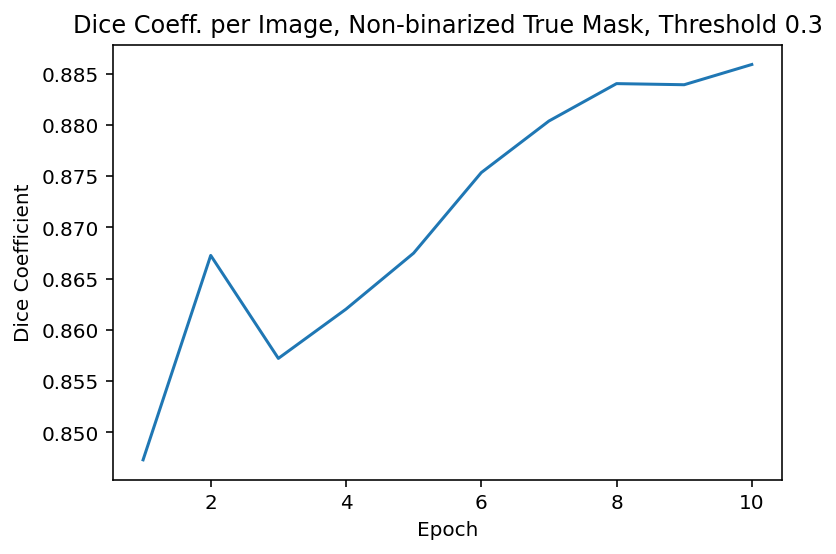

In [17]:
sns.lineplot(np.arange(1, NUM_EPOCHS+1), val_dice_arr)
plt.title("Dice Coeff. per Image, Non-binarized True Mask, Threshold 0.3")
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.savefig('Dice Coeff. per Image, Non-binarized True Mask, Threshold 0.3.png')

In [18]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('BCE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

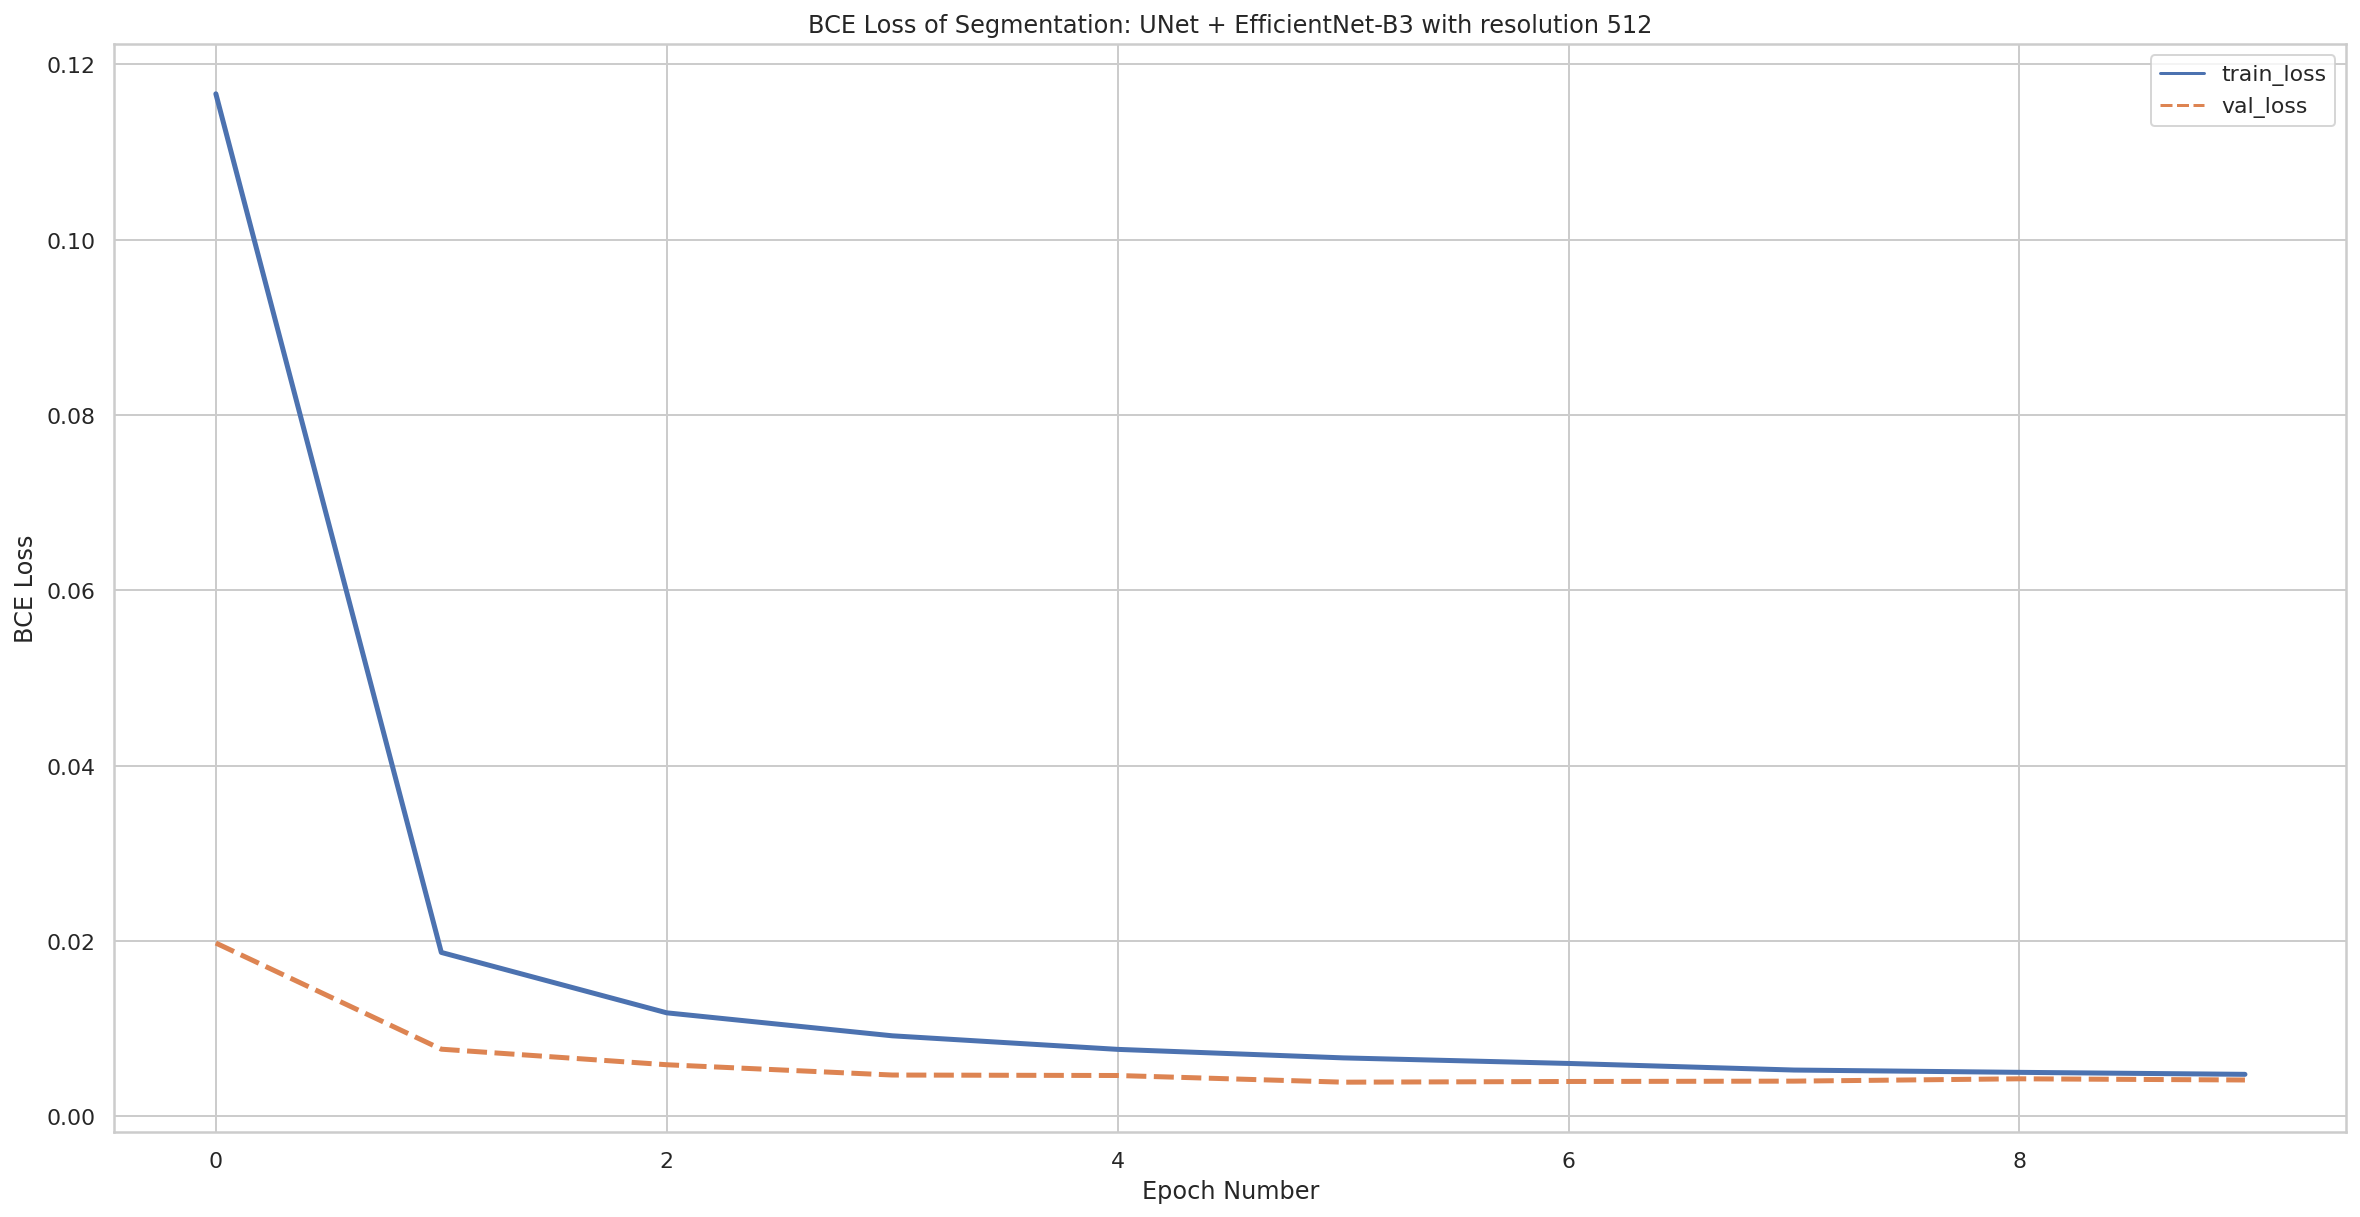

In [20]:
plot_both_loss(train_loss, val_loss, "Segmentation: UNet + EfficientNet-B3", str(RESOLUTION))

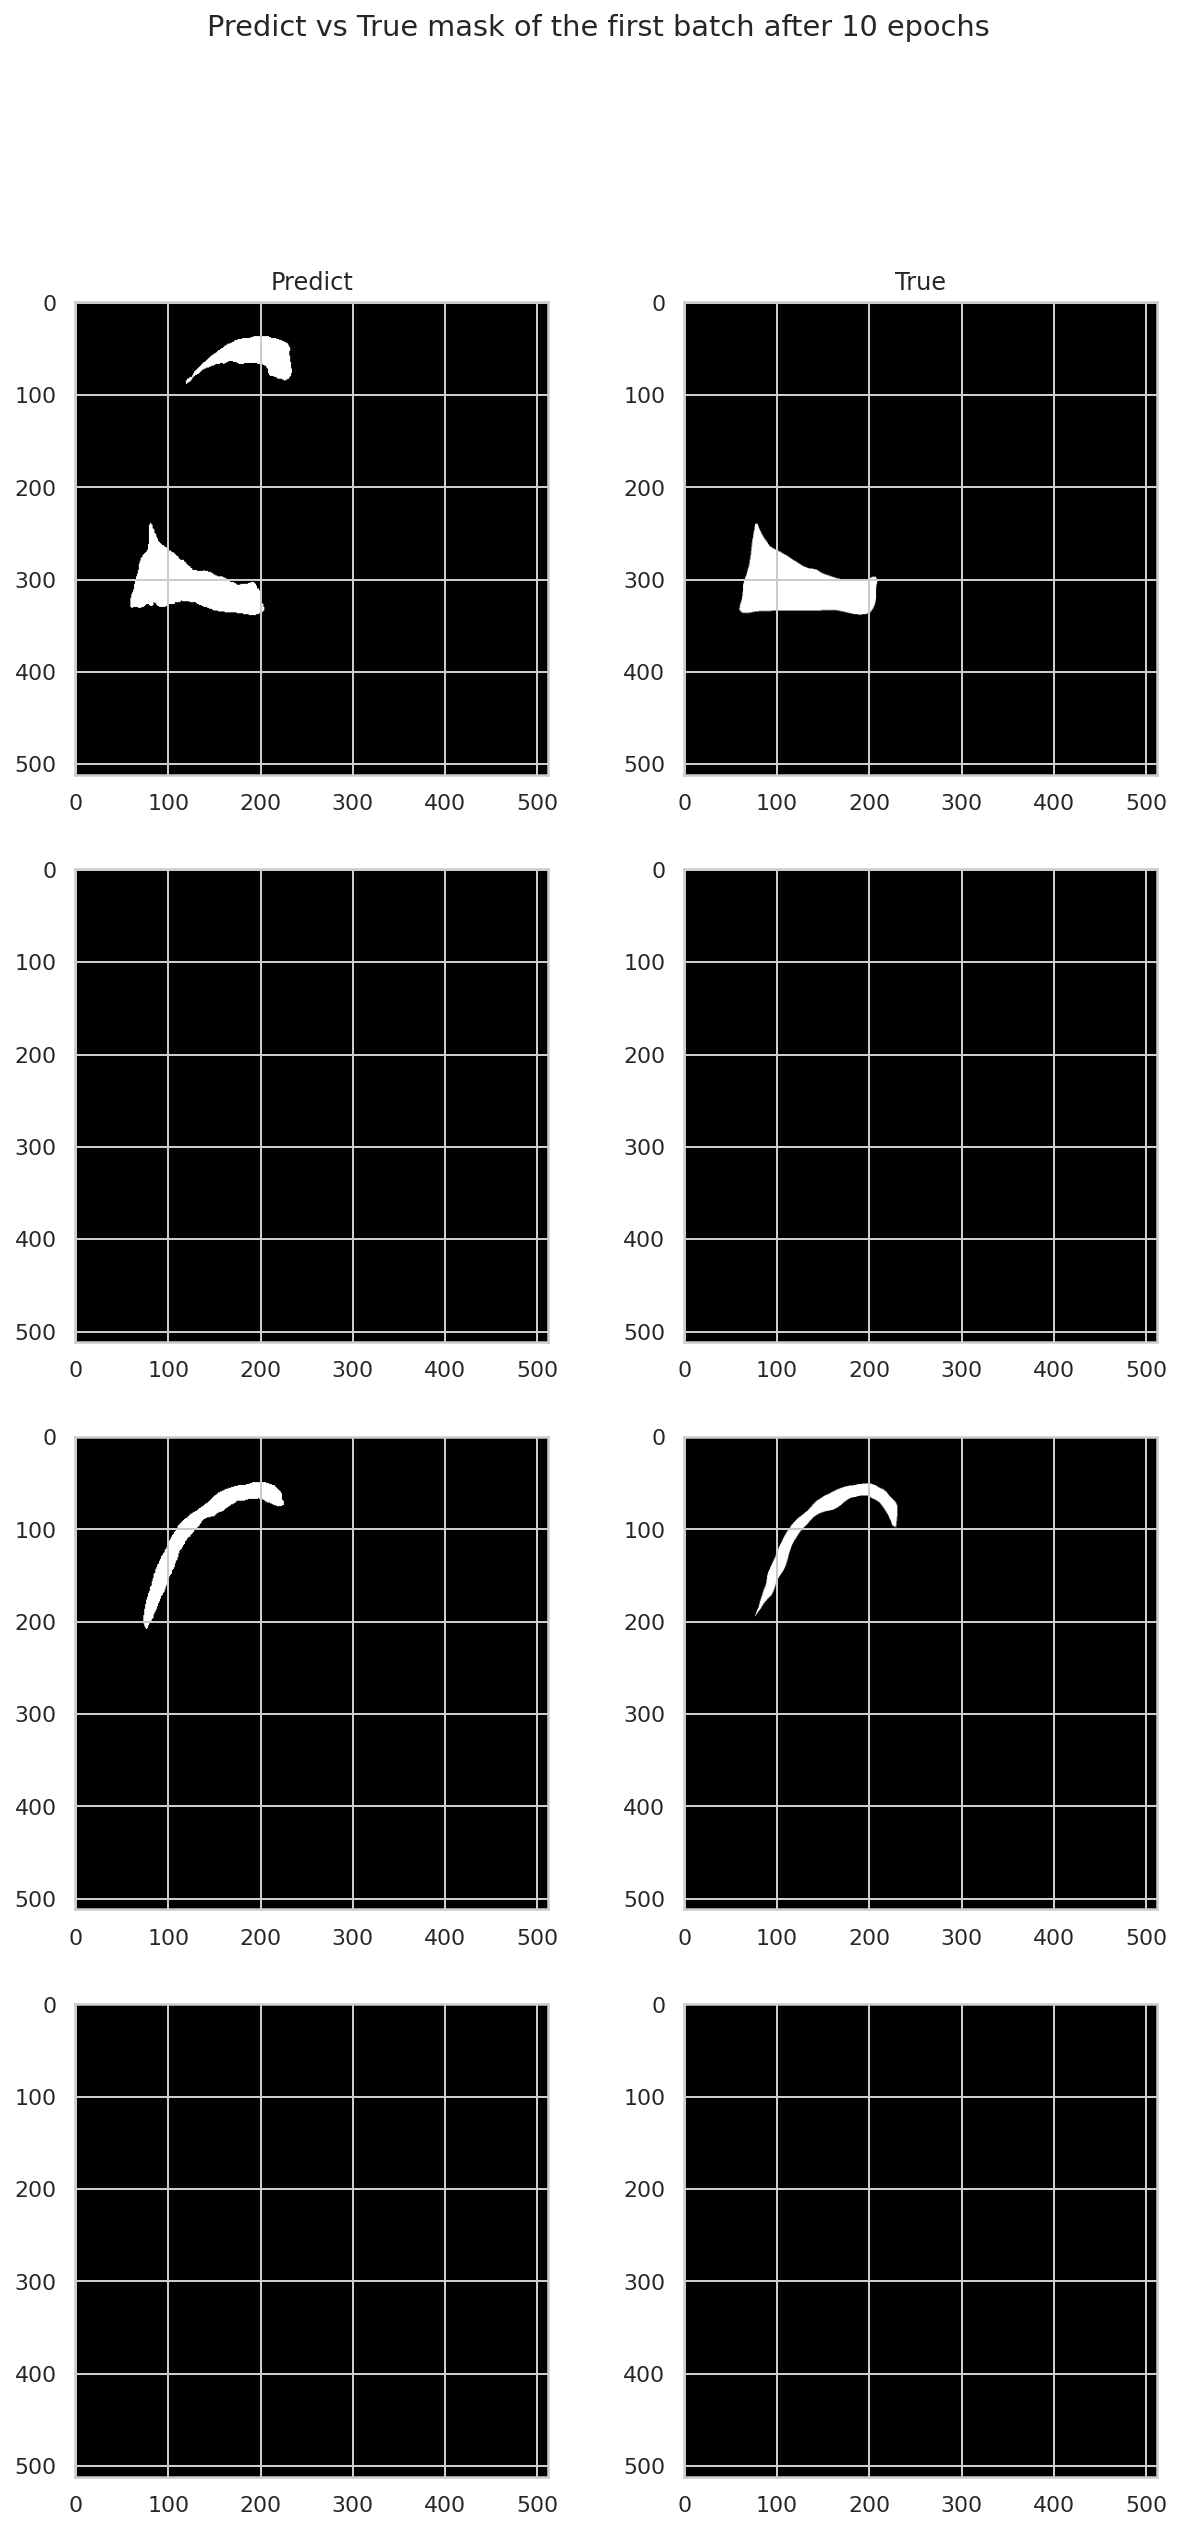

In [25]:
pred_1 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][0].squeeze())
pred_2 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][1].squeeze())
pred_3 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][2].squeeze())
pred_4 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][3].squeeze())

pred_1_bi = bi_mask(pred_1, THRESHOLD)
pred_2_bi = bi_mask(pred_2, THRESHOLD)
pred_3_bi = bi_mask(pred_3, THRESHOLD)
pred_4_bi = bi_mask(pred_4, THRESHOLD)

true_1 = true_mask[NUM_EPOCHS - 1][0].squeeze()
true_2 = true_mask[NUM_EPOCHS - 1][1].squeeze()
true_3 = true_mask[NUM_EPOCHS - 1][2].squeeze()
true_4 = true_mask[NUM_EPOCHS - 1][3].squeeze()

fig_size = (10, 20)
fig, axs = plt.subplots(4, 2, figsize = fig_size)
axs[0][0].imshow(pred_1_bi, cmap='gray')
axs[0][0].title.set_text('Predict')
axs[0][1].imshow(true_1, cmap='gray')
axs[0][1].title.set_text('True')
#plt.show()
axs[1][0].imshow(pred_2_bi, cmap='gray')
axs[1][1].imshow(true_2, cmap='gray')

#plt.show()
axs[2][0].imshow(pred_3_bi, cmap='gray')
axs[2][1].imshow(true_3, cmap='gray')

axs[3][0].imshow(pred_4_bi, cmap='gray')
axs[3][1].imshow(true_4, cmap='gray')

fig.suptitle('Predict vs True mask of the first batch after {} epochs'.format(str(NUM_EPOCHS)))
plt.show()

## Look at the images we saved! (Updated 2/26/2023)

In [47]:
predicted_path = train_df.iloc[0].Intermediate_Predicted_Path
img_path = train_df.iloc[0].XRay_Path

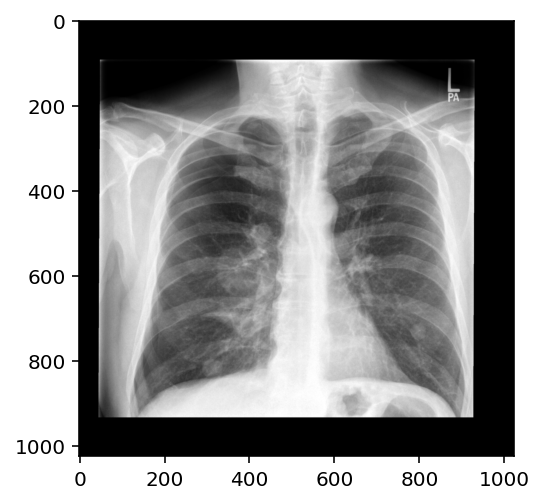

In [52]:
img = dicom.dcmread(img_path).pixel_array
plt.imshow(img, cmap = "gray")

In [65]:
img.shape

(1024, 1024)

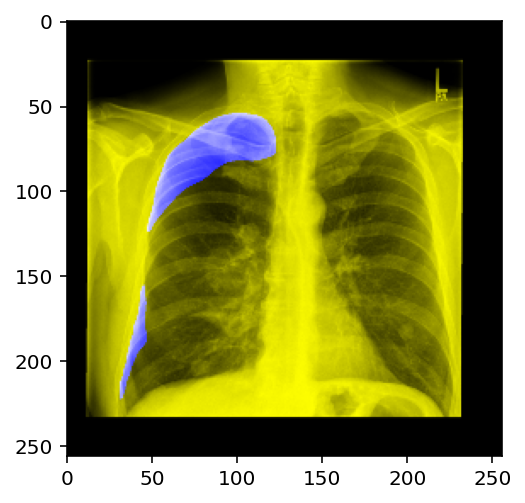

In [69]:
new_img = plt.imread(predicted_path)
plt.imshow(new_img[:, :, :3])

In [66]:
new_img[:, :, :3].shape

(256, 256, 3)

In [100]:
to_tensor = transforms.ToTensor()
test = to_tensor(sample[0][2])
test

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

## Rerun the training for 20 epochs

In [46]:
loaders_ens = create_loaders('E')


In [17]:
# ### Test dataloader
# ### NO DELETE!!!! 
# sample_iter = iter(loaders_ens[0])
# sample = next(sample_iter)
# sample_2 = next(sample_iter)
# print("--Check length of first batch, should be 2")
# print(len(sample))
# print("--Check size of input images of first batch, should be ([{}, {}, {}, {}])".format(BATCH_SIZE, 3, RESOLUTION, RESOLUTION))
# print(sample[0].size())
# print(sample[0][0])
# print("--Check size of labels/masks of first batch")
# print(sample[1].size())
# print(sample[1][0])

In [119]:
def training_class(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
#     all_preds = []
#     all_masks = []
#     all_xray = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, labels) in enumerate(train_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            
            
            if (i == 0) & (epoch == 0):
                print(preds)
                print(labels)

            
            loss = loss_fn(preds, labels)
    
            loss.backward()
            optimizer.step()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        print("LET'S START VALIDATION!!!")
        for i, (imgs, labels) in enumerate(val_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, labels) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.
            
#             if i == 1:
#                 all_preds.append(preds.detach().cpu())
#                 all_masks.append(masks.detach().cpu())
#                 all_xray.append(imgs.detach().cpu())
            
        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss#, all_preds, all_masks, all_xray

In [19]:
model_class = resnet34()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [22]:
# np.array([param for param in model_class.parameters()])

In [124]:
resnet_model, train_loss, val_loss = training_class(model = model_class,
                                            num_epochs = 20, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = loaders_ens[0], val_loader = loaders_ens[1])

  0%|          | 0/20 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([[ 0.6331, -0.3644],
        [ 0.2008, -0.2262],
        [-0.5089,  0.4087],
        [-0.1147, -0.0032]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]], device='cuda:0')
Total # of training batch:  1278
LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


LET'S START VALIDATION!!!


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


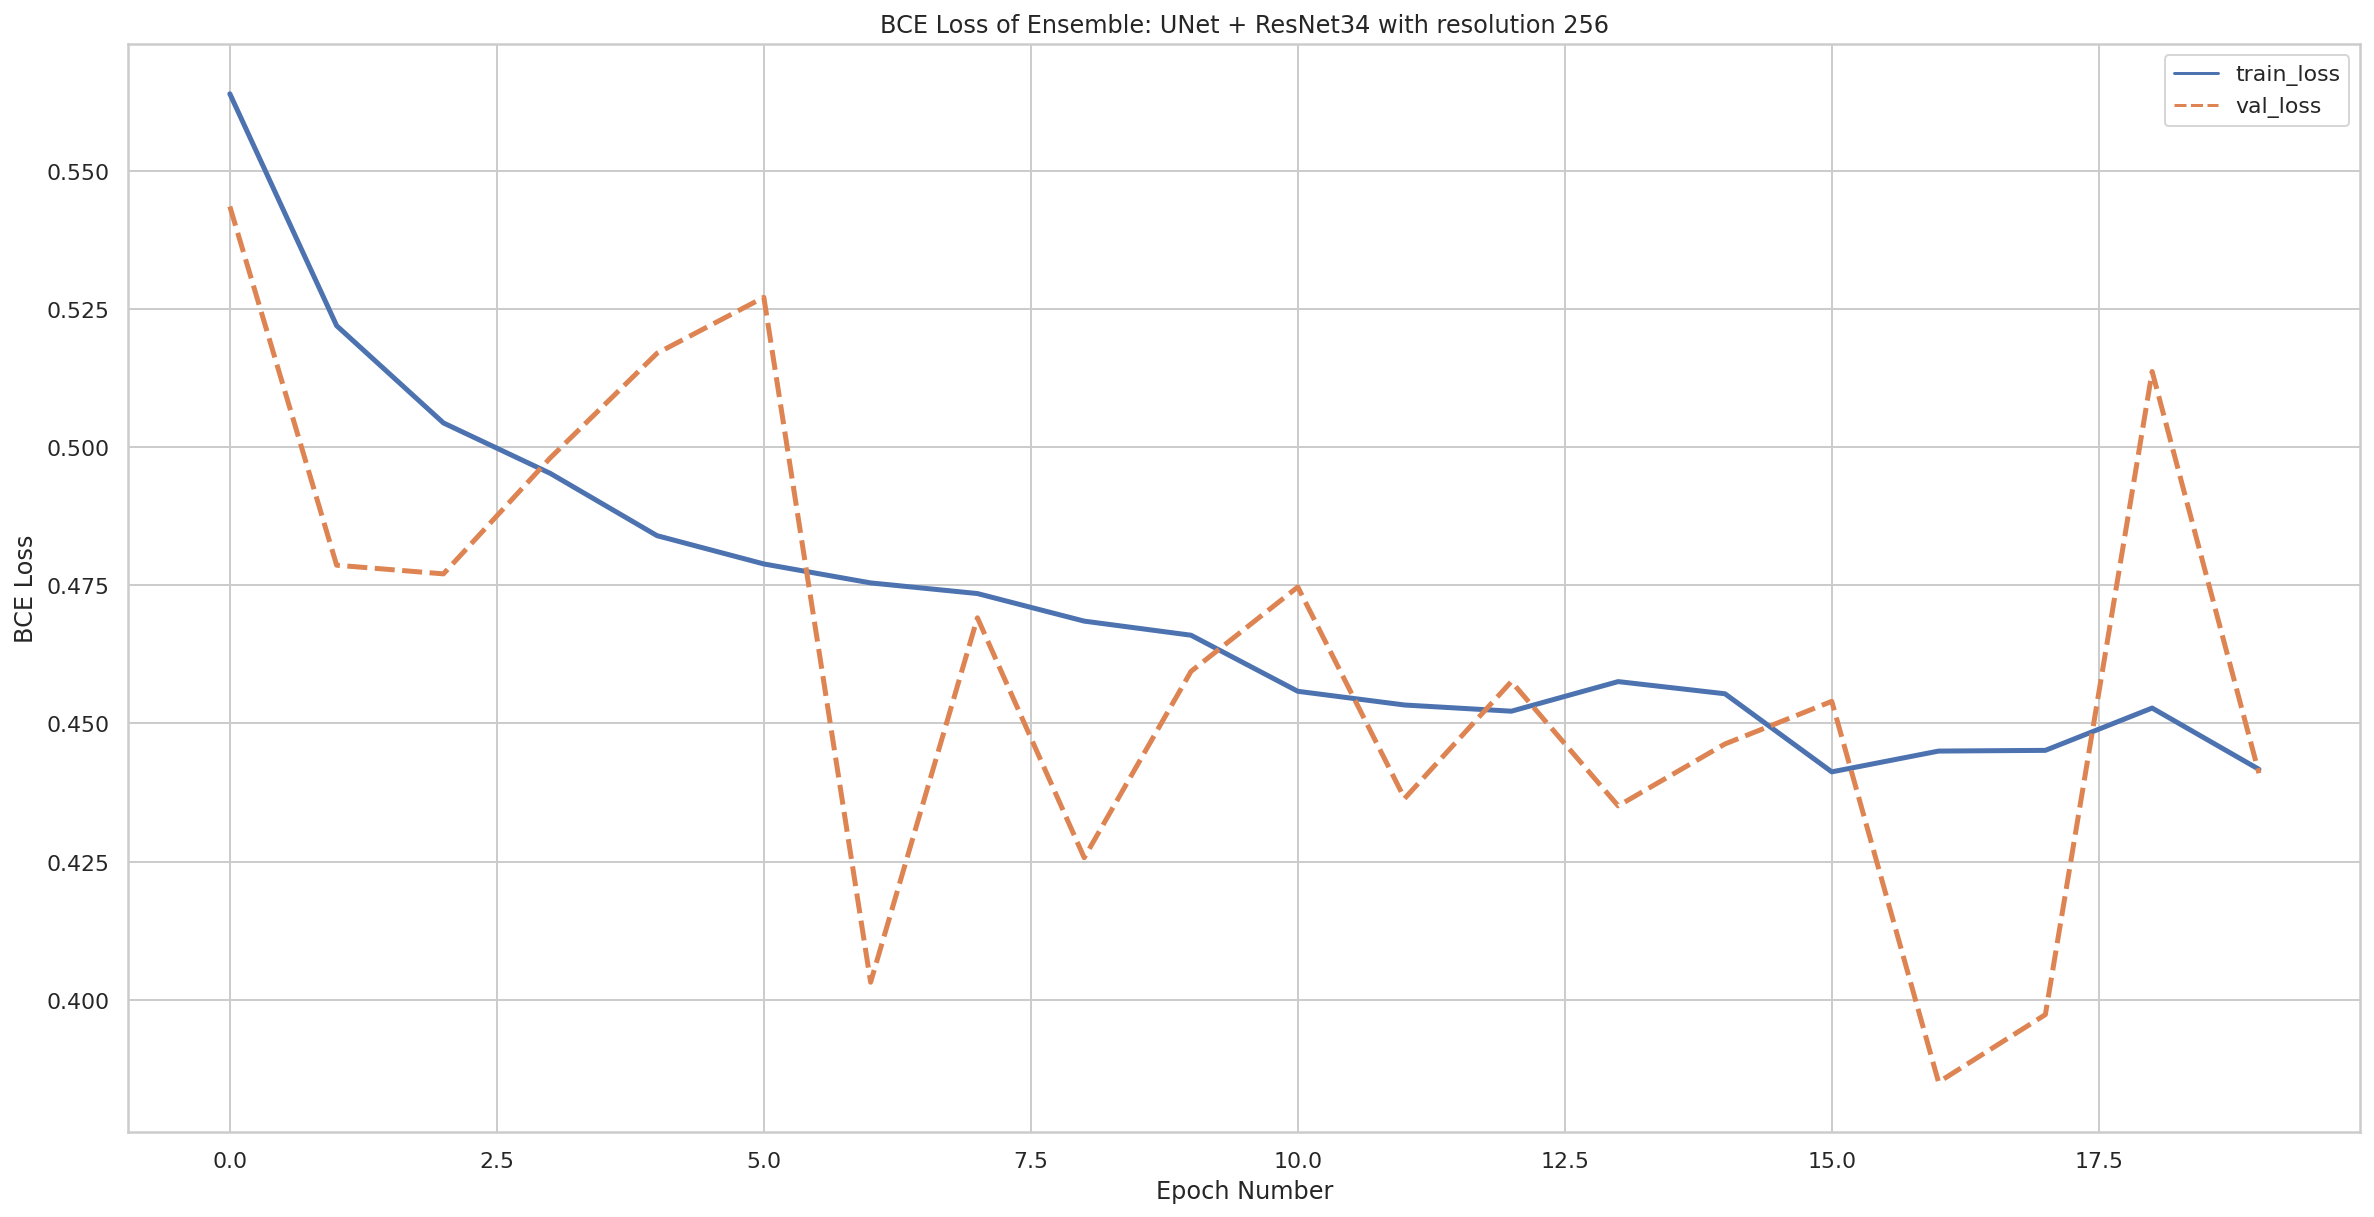

In [127]:
plot_both_loss(train_loss, val_loss, "Ensemble: UNet + ResNet34", str(RESOLUTION))

In [129]:
def plot_confusion_matrix(y_test, y_true, model_name, resolution):
    
    cm = confusion_matrix(y_true, y_test)

    sns.heatmap(cm, annot=True, cmap = 'Blues', fmt="d")
    plt.title('Confusion matrix of model {} with resolution {}'.format(model_name, resolution))
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

In [130]:
def plot_roc_curve(y_test, y_true, model_name, resolution):
    fpr, tpr, threshold = roc_curve(y_true, y_test, drop_intermediate = False)
    roc_auc = roc_auc_score(y_true, y_test)

    plt.figure(1)
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_name, roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve of model {} with resolution {}'.format(model_name, resolution))
    plt.legend(loc='best')
    plt.show()

In [136]:
def test_metrics(test_loader, model, model_name, resolution):
    """
    Calculate confusion matrix & auc-roc
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    total_num_batch = 0
    for i, (imgs, labels) in enumerate(test_loader):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        
        soft_max = nn.Softmax(dim=1)
        pred_prob = soft_max(preds).detach().cpu().numpy()
        
        pred_label = np.argmax(pred_prob, axis=1)
        true_label = labels.detach().cpu().numpy().astype(int)[:, 1]
        
        y_test = np.concatenate((y_test, pred_label))
        # add this line
        y_test_prob = np.concatenate((y_test, np.max(pred_prob, axis = 1)))
        # if the auc-roc curve still only have one point, chance the above line to this one
        # bug-free not guaranteed
        y_test_prob = np.concatenate((y_test, np.max(preds, axis = 1)))

    
        y_true = np.concatenate((y_true, true_label))
    
    plot_confusion_matrix(y_test, y_true, model_name, str(resolution))
    # modify this line, change from y_test to y_test_prob
    plot_roc_curve(y_test_prob, y_true, model_name, str(resolution))
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


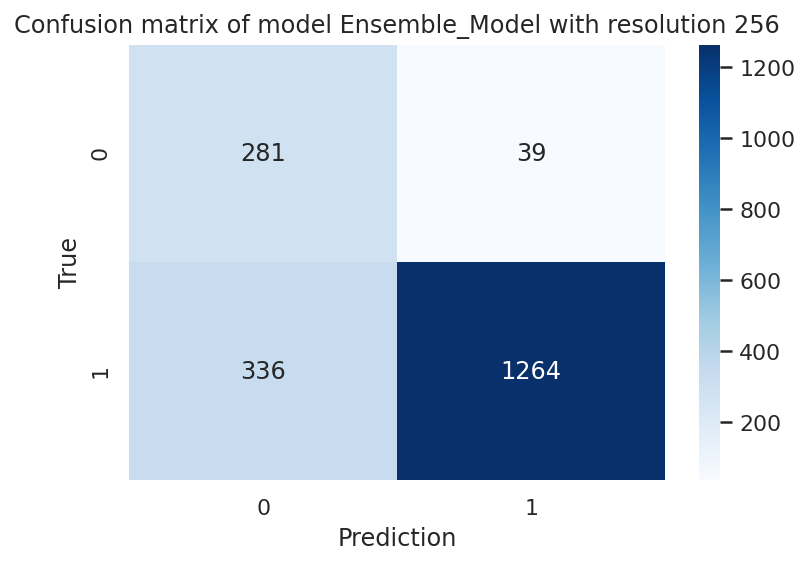

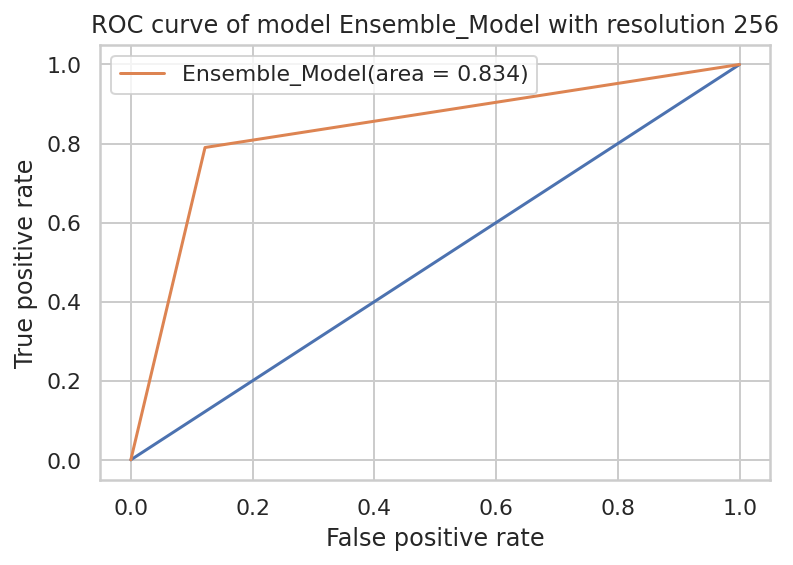

Total Number of Batch Size:  480


In [138]:
y_test, y_true = test_metrics(loaders_ens[2], resnet_model, 'Ensemble_Model', "256")

In [140]:
test_df.Yes_Pneumothorax.value_counts()

0    1600
1     320
Name: Yes_Pneumothorax, dtype: int64

In [144]:
sum(y_test == 1)

1303

In [145]:
sum(y_true == 1)

1600

_____________________________________________________________________________________________________________________________

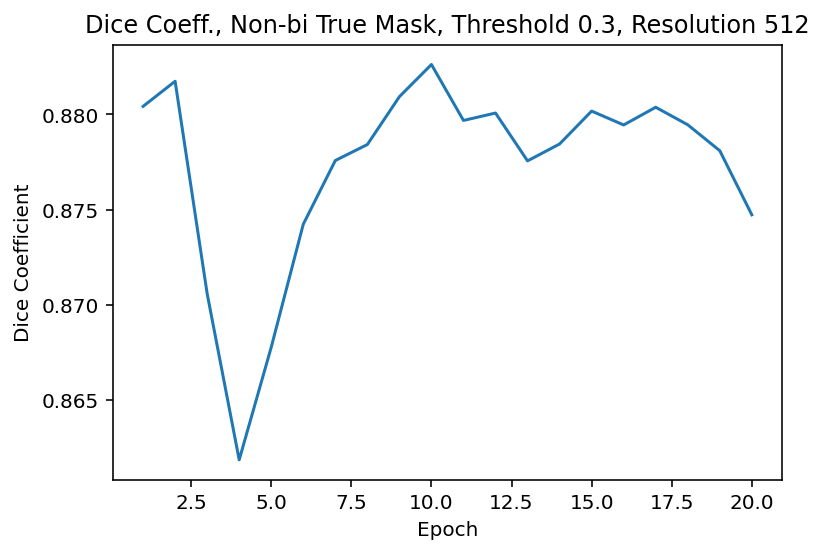

In [19]:
sns.lineplot(np.arange(1, 21), val_dice_arr)
plt.title("Dice Coeff., Non-bi True Mask, Threshold 0.3, Resolution 512")
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.savefig('Dice Coeff. per Image, Non-bi True Mask, Threshold 0.3, Resolution 512.png', dpi = 300)

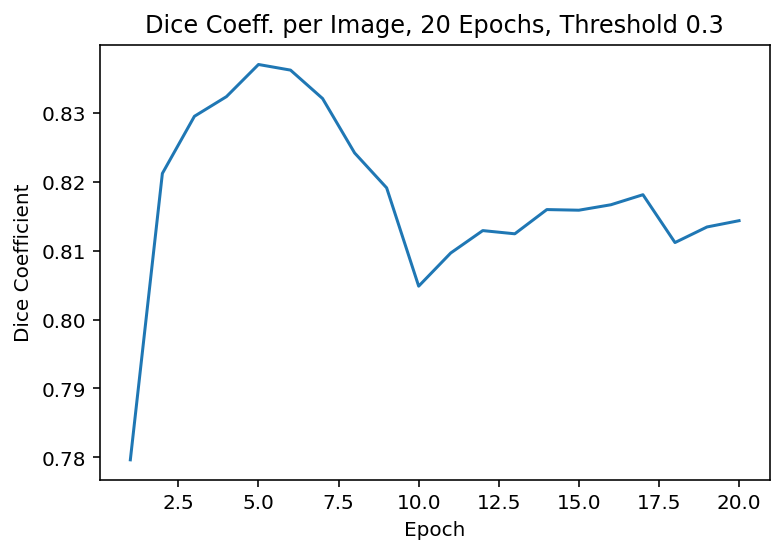

In [77]:
sns.lineplot(np.arange(1, 21), val_dice_epoch)
plt.title("Dice Coeff. per Image, 20 Epochs, Threshold 0.3")
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.savefig('Dice Coefficient per Image Over 20 Epochs of Segmentation Model with Threshold 0.3.png')

val_dice_epoch_bimask = [0.7796469213267898,
 0.8212088897592371,
 0.8295007077411394,
 0.8323541855833925,
 0.8370185884724045,
 0.8362016750566373,
 0.8320809249304167,
 0.8241835737737015,
 0.8191164830476185,
 0.804849093123987,
 0.8096617821605095,
 0.8129138814930792,
 0.8124474087689212,
 0.8159639622115291,
 0.8158723309276456,
 0.8166636037890302,
 0.8181208902830451,
 0.8111776767804043,
 0.8134409934842607,
 0.8143519276575074]

<AxesSubplot:>

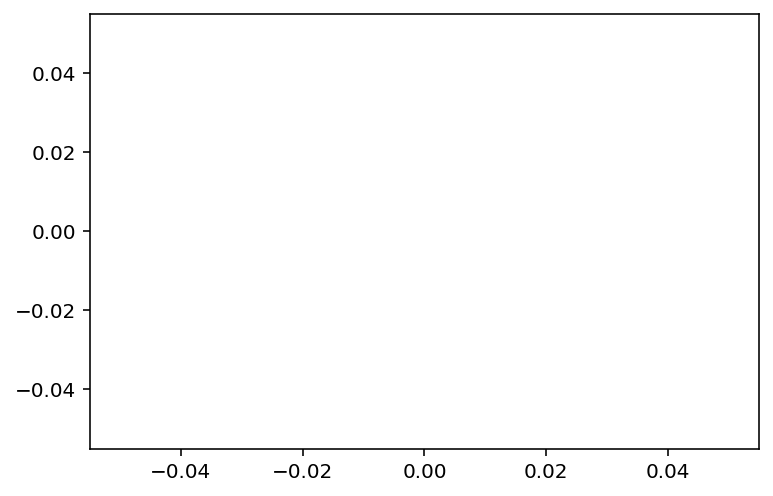

In [56]:
sns.lineplot(val_dice_arr)

In [36]:
len(true_mask[0])

4

In [37]:
######### test val_dice
pred = logit_mask[0]
masks = true_mask[0]
pred_bi = bi_mask(pred.detach().cpu().squeeze(), THRESHOLD)
test_dice = []
for i in range(4):
    cur_dc = calculate_dc(pred_bi[i], masks[i].detach().cpu().squeeze().numpy())
    test_dice.append(cur_dc)

np.mean(test_dice)
# cur_dc = calculate_dc(pred_bi, masks[j].detach().cpu().squeeze().numpy())
# dc_list.append(cur_dc)
# dc_list, avg = dice_coef_per_image(loaders_seg[2], unet_model, THRESHOLD)            
# val_dice.append(avg)



#########

In [42]:
test_dice = []
for i in range(4):
    cur_dc = calculate_dc(pred_bi[i], masks[i].detach().cpu().squeeze().numpy())
    test_dice.append(cur_dc)

np.mean(test_dice)

0.8026633466422589

In [40]:
np.mean(test_dice)

0.8026633466422589

In [44]:
masks.detach().cpu().squeeze().numpy().shape

(4, 256, 256)

In [25]:
len(logit_mask)

1

In [26]:
len(logit_mask[0])

4

In [31]:
logit_mask[0].squeeze().shape

torch.Size([4, 256, 256])

In [33]:
logit_mask[0][0][0]#.shape

tensor([[-2.2192, -3.0278, -2.8606,  ..., -2.1828, -2.5819, -1.5581],
        [-2.7805, -4.1317, -3.9864,  ..., -3.1070, -3.7405, -2.7540],
        [-3.3740, -4.5302, -4.1722,  ..., -3.8578, -4.3822, -2.6994],
        ...,
        [-2.8635, -4.0008, -3.5540,  ..., -3.1482, -3.8921, -2.5905],
        [-2.9892, -4.3781, -4.2172,  ..., -4.0760, -3.9785, -2.9327],
        [-1.5707, -2.1090, -2.2108,  ..., -2.2616, -1.9111, -1.3896]])

In [34]:
ori_xray[0][0][0]#.shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [51]:
torch.sum(true_mask[0][0][0] == true_mask[1][0][0])

tensor(65536)

In [45]:
true_mask[0][0][0].unique()#.shape

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [18]:
def dice_coef_per_image(test_loader, model, sigmoid_threshold):
    """
    Calculate dice coefficient from a test set. Based on the average of each dice coefficient.
    Return a list 
    """
    dc_list = []
    total_num_batch = 0
    for i, (imgs, masks) in enumerate(test_loader):
        total_num_batch += 1
        imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        for j in range(BATCH_SIZE):
            pred = preds[j].detach().cpu().squeeze()
            pred_bi = bi_mask(pred, sigmoid_threshold)
            cur_dc = calculate_dc(pred_bi, masks[j].detach().cpu().squeeze().numpy())
            dc_list.append(cur_dc)
    print('Total Number of Batch Size: ', total_num_batch)
    return dc_list, np.mean(dc_list)

In [20]:
dc_list, avg = dice_coef_per_image(loaders_seg[2], unet_model, 0.3)
print(avg)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total Number of Batch Size:  480
0.7308782676969928


dice_avg_1_nonbi = 0.8723006845597181

dice_avg_2_nonbi = 0.8662950791858317

dice_epoch3_bimask = 0.7308782676969928

dice_epoch20_bimask = ?

<hr>

- get the model and run on all three datasets
    - logit_mask 
    - ori_xray - save the XRay_Path?
    - label ([0, 1] or [1, 0])  -- [['Yes_Pneumothorax', 'No_Pneumothorax']]
- get three new csv
- create new datasets & dataloader
- feed into the classification model


<hr>

In [ ]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
    
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation
        self.model_type = model_type
                  
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        if self.model_type == 'C':
            label = self.labels[idx]
            
            return img_norm, label
        
        elif self.model_type == 'S':
            mask_path = self.mask_paths[idx]
            mask = plt.imread(mask_path)[:, :, 0]
            mask = cv2.resize(mask, (self.resolution, self.resolution))
            mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 

            return img_norm, mask

In [ ]:
plot_both_loss(train_loss, val_loss, 'resnet34+unet', str(RESOLUTION))